In [1]:
import glob
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
files = glob.glob('/Users/alexaowen/Downloads/archive (4).zip')
files

['/Users/alexaowen/Downloads/archive (4).zip']

In [3]:
files

['/Users/alexaowen/Downloads/archive (4).zip']

In [4]:
for file in files:
    print('Unzipping:',file)

    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('data/raw')

Unzipping: /Users/alexaowen/Downloads/archive (4).zip


In [7]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  "Plants_2",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4502 files belonging to 4 classes.
Using 3602 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "Plants_2",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4502 files belonging to 4 classes.
Using 900 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['images to predict', 'test', 'train', 'valid']


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0056645414 0.46096686


In [29]:
num_classes = len(class_names)

model_A = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [30]:
model_A.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model_A.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [53]:
epochs=10
history_A = model_A.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
113/113 [==============================] - 39s 343ms/step - loss: 0.0660 - accuracy: 0.9806 - val_loss: 0.6259 - val_accuracy: 0.9489
Epoch 2/10
113/113 [==============================] - 37s 331ms/step - loss: 0.0398 - accuracy: 0.9886 - val_loss: 0.6294 - val_accuracy: 0.9411
Epoch 3/10
113/113 [==============================] - 40s 350ms/step - loss: 0.0423 - accuracy: 0.9856 - val_loss: 0.7298 - val_accuracy: 0.9467
Epoch 4/10
113/113 [==============================] - 38s 339ms/step - loss: 0.0283 - accuracy: 0.9925 - val_loss: 0.6747 - val_accuracy: 0.9233
Epoch 5/10
113/113 [==============================] - 38s 332ms/step - loss: 0.0174 - accuracy: 0.9961 - val_loss: 0.7888 - val_accuracy: 0.9356
Epoch 6/10
113/113 [==============================] - 40s 353ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.1026 - val_accuracy: 0.9478
Epoch 7/10
113/113 [==============================] - 46s 404ms/step - loss: 8.0739e-04 - accuracy: 1.0000 - val_loss: 1.1595 - va

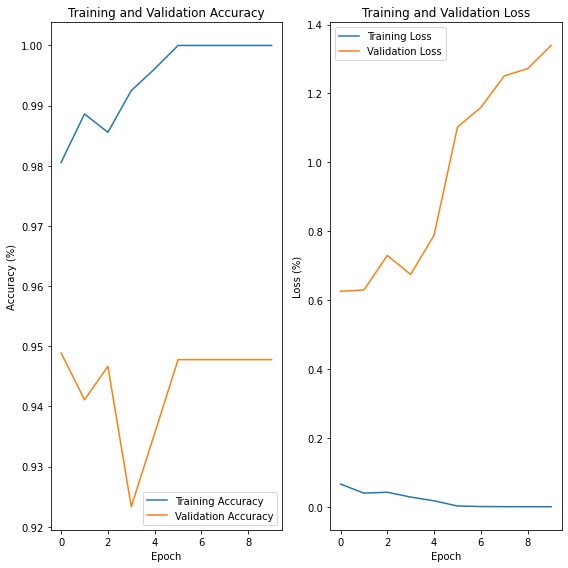

In [56]:
acc = history_A.history['accuracy']
val_acc = history_A.history['val_accuracy']

loss = history_A.history['loss']
val_loss = history_A.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (%)")
plt.tight_layout()
plt.show()


In [43]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [44]:
model_B = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [45]:
model_B.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
model_B.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [47]:
epochs = 15
history_B = model_B.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
113/113 [==============================] - 42s 362ms/step - loss: 0.2895 - accuracy: 0.9448 - val_loss: 0.2456 - val_accuracy: 0.9500
Epoch 2/15
113/113 [==============================] - 41s 361ms/step - loss: 0.2524 - accuracy: 0.9492 - val_loss: 0.2487 - val_accuracy: 0.9500
Epoch 3/15
113/113 [==============================] - 44s 386ms/step - loss: 0.2503 - accuracy: 0.9492 - val_loss: 0.2415 - val_accuracy: 0.9500
Epoch 4/15
113/113 [==============================] - 46s 409ms/step - loss: 0.2516 - accuracy: 0.9492 - val_loss: 0.2487 - val_accuracy: 0.9500
Epoch 5/15
113/113 [==============================] - 47s 415ms/step - loss: 0.2479 - accuracy: 0.9492 - val_loss: 0.2612 - val_accuracy: 0.9500
Epoch 6/15
113/113 [==============================] - 47s 412ms/step - loss: 0.2473 - accuracy: 0.9492 - val_loss: 0.2442 - val_accuracy: 0.9500
Epoch 7/15
113/113 [==============================] - 43s 378ms/step - loss: 0.2502 - accuracy: 0.9492 - val_loss: 0.2424 - val_ac

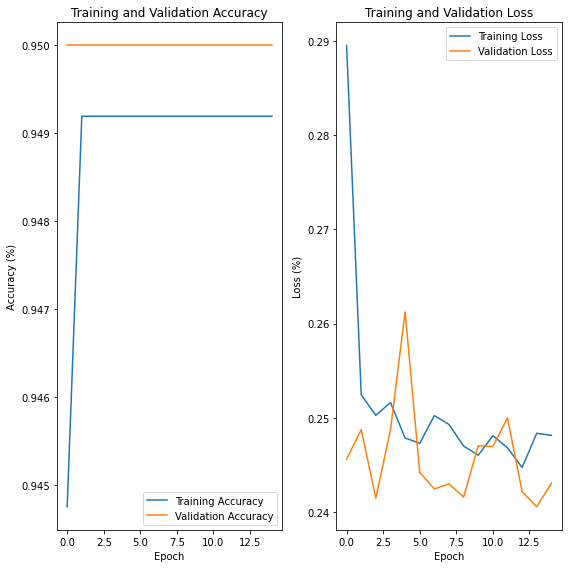

In [52]:
acc = history_B.history['accuracy']
val_acc = history_B.history['val_accuracy']

loss = history_B.history['loss']
val_loss = history_B.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epoch")
plt.ylabel("Loss (%)")
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.show()